In [1]:
import torch
from RzLinear import RzLinear 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# checkout the mapping

In [6]:
weight_size = 100
input_dim = 10
output_dim = 10
chunk_size = 4

#hashed_weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1/np.sqrt(input_dim), 1/np.sqrt(input_dim), size=((weight_size,))).astype(np.float32)))
hashed_weight = nn.Parameter(torch.from_numpy(np.arange(weight_size).astype(np.float32)))
rzlinear = RzLinear(input_dim, output_dim, chunk_size, hashed_weight).to("cuda:0");

input_v = torch.eye(input_dim).to("cuda:0")
output_v = rzlinear(input_v)
print(output_v)


RandomNumbers:  tensor([2038074743,  634329019, 1825252241,  871205356,   80759397])
RzLinear: d1xd2: 10x10 chunk_size: 4 weight_size: 100
tensor([[19., 17., 15., 56., 54., 52., 50., 48., 46., 44.],
        [20., 18., 16., 57., 55., 53., 51., 49., 47., 45.],
        [21., 19., 17., 58., 56., 54., 52., 50., 48., 46.],
        [22., 20., 18., 59., 57., 55., 53., 51., 49., 47.],
        [75., 73., 71., 69., 67., 65., 63., 61.,  2.,  0.],
        [76., 74., 72., 70., 68., 66., 64., 62.,  3.,  1.],
        [77., 75., 73., 71., 69., 67., 65., 63.,  4.,  2.],
        [78., 76., 74., 72., 70., 68., 66., 64.,  5.,  3.],
        [88., 86., 27., 25., 23., 21., 19., 17., 15., 13.],
        [89., 87., 28., 26., 24., 22., 20., 18., 16., 14.]], device='cuda:0',
       grad_fn=<RzLinearFunctionBackward>)


# Checkout the Randomness

RandomNumbers:  tensor([2038074743,  634329019, 1825252241,  871205356,   80759397])
RzLinear: d1xd2: 1000x1000 chunk_size: 2 weight_size: 100
torch.Size([1000, 1000])


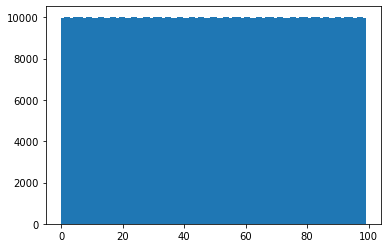

In [7]:

weight_size = 100
input_dim = 1000
output_dim = 1000
chunk_size = 2

#hashed_weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1/np.sqrt(input_dim), 1/np.sqrt(input_dim), size=((weight_size,))).astype(np.float32)))
hashed_weight = nn.Parameter(torch.from_numpy(np.arange(weight_size).astype(np.float32)))
rzlinear = RzLinear(input_dim, output_dim, chunk_size, hashed_weight).to("cuda:0");

input_v = torch.eye(input_dim).to("cuda:0")
output_v = rzlinear(input_v)
print(output_v.shape)


plt.hist(np.array(output_v.detach().cpu()).reshape(-1), bins = int(input_dim/10))
plt.show()



# Checkout the correctness of forward pass

In [2]:
weight_size = 100
input_dim = 1000
output_dim = 1000
chunk_size = 5

hashed_weight = nn.Parameter(torch.from_numpy(np.arange(weight_size).astype(np.float32)))
rzlinear = RzLinear(input_dim, output_dim, chunk_size, hashed_weight).to("cuda:0");
input_v = torch.eye(input_dim).to("cuda:0")
idx_matrix = rzlinear(input_v).long()


RandomNumbers:  tensor([2038074743,  634329019, 1825252241,  871205356,   80759397])
RzLinear: d1xd2: 1000x1000 chunk_size: 5 weight_size: 100


In [3]:
idx_matrix.long()

tensor([[19, 17, 15,  ..., 97, 95, 36],
        [20, 18, 16,  ..., 98, 96, 37],
        [21, 19, 17,  ..., 99, 97, 38],
        ...,
        [10,  8,  6,  ..., 88, 86, 84],
        [11,  9,  7,  ..., 89, 87, 85],
        [12, 10,  8,  ..., 90, 88, 86]], device='cuda:0')

In [4]:
hashed_weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1,1, size=(weight_size,)).astype(np.float32)))
rzlinear = RzLinear(input_dim, output_dim, chunk_size, hashed_weight).to("cuda:0");


RandomNumbers:  tensor([2038074743,  634329019, 1825252241,  871205356,   80759397])
RzLinear: d1xd2: 1000x1000 chunk_size: 5 weight_size: 100


In [5]:
out = rzlinear(input_v)

In [6]:
matrix = hashed_weight[idx_matrix]

In [7]:
ground_truth = torch.matmul(input_v, matrix)

In [8]:
if torch.norm(out - ground_truth) == 0:
    print("All OK")
else:
    print("Issue in forward pass")

All OK


# Check Backprop

In [2]:
from RzLinear import RzLinearFunction
import torch
from RzLinear import RzLinear 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [20]:
weight_size = 10
input_dim = 10
output_dim = 10
chunk_size = 5
seed = 1024
r = np.random.RandomState(seed)
# first number is the prime, rest are random integers
random_numbers = torch.from_numpy(np.concatenate([np.array([2038074743]), r.randint(0, 2038074743, (50,))])).to("cuda:0") # set of 50 random numbers to use


hashed_weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,weight_size).astype(np.float32))).to("cuda:0")
input_v = torch.rand((5,input_dim)).to("cuda:0")
#input_v = torch.eye(2).to("cuda:0")

In [21]:
def myFunc(hashed_weight, input_v, random_numbers, input_dim, output_dim, chunk_size ):
    out = RzLinearFunction.forwardproxy(hashed_weight, input_v, random_numbers, input_dim, output_dim, chunk_size )
    return out, 1/input_v.shape[0] * torch.sum(out**2)

In [22]:
out, val = myFunc(hashed_weight, input_v, random_numbers, input_dim, output_dim, chunk_size )

In [23]:
grad= 2*out / input_v.shape[0]

In [24]:
wt_grad, in_grad = RzLinearFunction.backwardproxy(grad, hashed_weight, input_v, random_numbers, input_dim, output_dim, chunk_size )

In [25]:
wt_grad

tensor([-12.6484,  -9.5888,  -8.8386, -12.2865, -15.3563, -11.7345, -16.2864,
        -14.1761, -14.9296, -10.5635], device='cuda:0')

In [26]:
in_grad

tensor([[ 1.6687,  0.7597,  1.4698,  0.8482,  1.9203,  0.2868,  1.7425,  0.2364,
          2.0467,  0.9236],
        [ 1.2055,  0.7961,  1.4715,  0.6152,  2.1190,  0.2717,  1.8941,  0.0451,
          2.2434,  0.8557],
        [ 2.8571,  0.8230,  2.8451,  0.6676,  3.1343,  0.2012,  2.8067,  0.2628,
          2.4895,  1.8260],
        [ 2.4139,  0.5300,  1.8274,  1.0924,  2.5395,  0.6820,  2.4013, -0.2016,
          1.7088,  1.3852],
        [ 2.0194,  0.8356,  1.6253,  0.6686,  2.3886,  0.6185,  2.5521, -0.3131,
          2.3051,  1.2970]], device='cuda:0')

In [27]:
epsilon = 1e-4
_, f0 = myFunc(hashed_weight, input_v, random_numbers, input_dim, output_dim, chunk_size )
hwt_grad = torch.empty_like(hashed_weight)
for i in range(len(hashed_weight)):
    hwt = hashed_weight.clone()
    hwt[i] += epsilon
    _, fi = myFunc(hwt, input_v, random_numbers, input_dim, output_dim, chunk_size )
    hwt_grad[i] = (fi - f0) / epsilon
    
    

In [28]:
print ("error norm", torch.norm(hwt_grad - wt_grad))
print(hwt_grad[:10])
print(wt_grad[:10])

error norm tensor(0.0501, device='cuda:0')
tensor([-12.6648,  -9.6130,  -8.8501, -12.2833, -15.3542, -11.7493, -16.2888,
        -14.1907, -14.9536, -10.5858], device='cuda:0')
tensor([-12.6484,  -9.5888,  -8.8386, -12.2865, -15.3563, -11.7345, -16.2864,
        -14.1761, -14.9296, -10.5635], device='cuda:0')


In [29]:
epsilon = 1e-4
_, f0 = myFunc(hashed_weight, input_v, random_numbers, input_dim, output_dim, chunk_size )
int_grad = torch.empty_like(input_v)
for i in range(int_grad.shape[0]):
    for j in range(int_grad.shape[1]):
        inputt = input_v.clone()
        inputt[i][j] += epsilon
        _, fi = myFunc(hashed_weight, inputt, random_numbers, input_dim, output_dim, chunk_size)
        int_grad[i][j] = (fi - f0) / epsilon
    
    

In [30]:
print ("error norm", torch.norm(int_grad - in_grad))
print(int_grad[:5,:5])
print(in_grad[:5,:5])

error norm tensor(0.0797, device='cuda:0')
tensor([[1.6594, 0.7439, 1.4687, 0.8392, 1.9073],
        [1.2016, 0.8011, 1.4687, 0.6104, 2.1172],
        [2.8419, 0.8011, 2.8229, 0.6485, 3.1281],
        [2.4033, 0.5341, 1.8120, 1.0872, 2.5368],
        [2.0027, 0.8392, 1.6212, 0.6485, 2.3842]], device='cuda:0')
tensor([[1.6687, 0.7597, 1.4698, 0.8482, 1.9203],
        [1.2055, 0.7961, 1.4715, 0.6152, 2.1190],
        [2.8571, 0.8230, 2.8451, 0.6676, 3.1343],
        [2.4139, 0.5300, 1.8274, 1.0924, 2.5395],
        [2.0194, 0.8356, 1.6253, 0.6686, 2.3886]], device='cuda:0')
